# Advanced Modelling

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
import sklearn
from pycaret.classification import *      #importing all functions of classification module of pycaret.

In [11]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [2]:
#Loading Train and Test data.
data_train=pd.read_csv('train_data.csv')            #this is train data from Phase 3 after random splitting and standardisation
data_test=pd.read_csv('test_data.csv')              #this is test data from Phase 3 .

In [3]:
#data_train.set_index("Unnamed: 0",inplace=True)  
#data_test.set_index("Unnamed: 0",inplace=True)
#setting index column to this so that we have same sync with initial processed data

data_train.drop(['Unnamed: 0'],axis=1,inplace=True)
data_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
setup1 = setup(data = data_train,test_data=data_test, target = 'PotentialFraud', session_id=100 , n_jobs=1) 
#this function must be executed to do any model building on Pycaret

,Description,Value
0,session_id,100
1,Target,PotentialFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(446568, 113)"
5,Missing Values,False
6,Numeric Features,101
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
save_config('my_config')

In [41]:
#Loading previously built models in Phase 3.
lightgbm=load_model('lightgbm')
rf=load_model('rf')
gbc=load_model('gbc')
ada=load_model('ada')
dt=load_model('dt')
qda=load_model('qda')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Now we will create a stacking model. In stacking model , the different the models are the better the resulting clasifier would be. In above models , we will also include qda as it has high recall. We will also include adaboost , random forest , and lightgbm.

In [46]:
stacker = stack_models([qda, rf, lightgbm,ada], fold = 3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6310,0.5694,0.1027,0.5926,0.1750,0.0704,0.1158
1,0.6321,0.5652,0.1027,0.6027,0.1756,0.0726,0.1202
2,0.6297,0.5649,0.0987,0.5846,0.1689,0.0660,0.1098
Mean,0.6309,0.5665,0.1014,0.5933,0.1732,0.0697,0.1153
SD,0.0010,0.0021,0.0019,0.0074,0.0030,0.0027,0.0043


Observation: We see that we are not getting good results with the stacking model. We will try some other combination.It is similar to out baseline logistics regression model.

In [47]:
stacker1 = stack_models([qda, rf, lightgbm], fold = 3)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6311,0.5658,0.1012,0.5946,0.1730,0.0698,0.1158
1,0.6319,0.5747,0.1019,0.6016,0.1742,0.0718,0.1192
2,0.6301,0.5611,0.1007,0.5865,0.1720,0.0678,0.1119
Mean,0.6310,0.5672,0.1013,0.5942,0.1731,0.0698,0.1156
SD,0.0007,0.0056,0.0005,0.0062,0.0009,0.0016,0.0030


The scores are still low. Pycaret by default uses the meta model as logistics regression. We will try using some other model
as meta model and see if performance improves.

In [48]:
stacker2 = stack_models([qda, rf, ada], fold = 3,meta_model = dt) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8327,0.8249,0.7920,0.7743,0.7830,0.6469,0.6470
1,0.8327,0.8246,0.7906,0.7750,0.7827,0.6467,0.6468
2,0.8281,0.8200,0.7863,0.7681,0.7771,0.6372,0.6373
Mean,0.8312,0.8232,0.7896,0.7725,0.7810,0.6436,0.6437
SD,0.0022,0.0022,0.0024,0.0031,0.0027,0.0045,0.0045


In [49]:
predict_model(stacker2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.6543,0.6324,0.5400,0.5473,0.5436,0.2655,0.2655


,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,...,Mean_OPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_3,NoOfMonths_PartACov_0,NoOfMonths_PartACov_1,NoOfMonths_PartACov_10,NoOfMonths_PartACov_11,NoOfMonths_PartACov_12,NoOfMonths_PartACov_2,NoOfMonths_PartACov_3,NoOfMonths_PartACov_4,NoOfMonths_PartACov_5,NoOfMonths_PartACov_6,NoOfMonths_PartACov_7,NoOfMonths_PartACov_8,NoOfMonths_PartACov_9,NoOfMonths_PartBCov_0,NoOfMonths_PartBCov_1,NoOfMonths_PartBCov_10,NoOfMonths_PartBCov_11,NoOfMonths_PartBCov_12,NoOfMonths_PartBCov_2,NoOfMonths_PartBCov_3,NoOfMonths_PartBCov_4,NoOfMonths_PartBCov_5,NoOfMonths_PartBCov_6,NoOfMonths_PartBCov_7,NoOfMonths_PartBCov_8,NoOfMonths_PartBCov_9,inOut_1.0,whetherAlive_1.0,PatientRiskValue_0,PatientRiskValue_1,PatientRiskValue_10,PatientRiskValue_11,PatientRiskValue_12,PatientRiskValue_2,PatientRiskValue_3,PatientRiskValue_4,PatientRiskValue_5,PatientRiskValue_6,PatientRiskValue_7,PatientRiskValue_8,Pa

Observation: From the above model , we can see that all the performance metrics on train data have better performance with this stack model which uses decision tree as meta classifier.

In [53]:
stacker3 = stack_models([qda, rf, ada], fold = 3,meta_model = dt,restack=False) 

#When we set restack=False , predictions as well as the original training data is used for training meta-model.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8188,0.8123,0.7513,0.7682,0.7596,0.6142,0.6143
1,0.8217,0.8135,0.7553,0.7720,0.7636,0.6205,0.6206
2,0.8184,0.8097,0.7479,0.7692,0.7584,0.6129,0.6131
Mean,0.8196,0.8118,0.7515,0.7698,0.7605,0.6159,0.6160
SD,0.0015,0.0016,0.0030,0.0016,0.0022,0.0033,0.0033


In [54]:
predict_model(stacker3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.6587,0.6306,0.5082,0.5574,0.5316,0.2640,0.2647


,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,...,Mean_OPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_3,NoOfMonths_PartACov_0,NoOfMonths_PartACov_1,NoOfMonths_PartACov_10,NoOfMonths_PartACov_11,NoOfMonths_PartACov_12,NoOfMonths_PartACov_2,NoOfMonths_PartACov_3,NoOfMonths_PartACov_4,NoOfMonths_PartACov_5,NoOfMonths_PartACov_6,NoOfMonths_PartACov_7,NoOfMonths_PartACov_8,NoOfMonths_PartACov_9,NoOfMonths_PartBCov_0,NoOfMonths_PartBCov_1,NoOfMonths_PartBCov_10,NoOfMonths_PartBCov_11,NoOfMonths_PartBCov_12,NoOfMonths_PartBCov_2,NoOfMonths_PartBCov_3,NoOfMonths_PartBCov_4,NoOfMonths_PartBCov_5,NoOfMonths_PartBCov_6,NoOfMonths_PartBCov_7,NoOfMonths_PartBCov_8,NoOfMonths_PartBCov_9,inOut_1.0,whetherAlive_1.0,PatientRiskValue_0,PatientRiskValue_1,PatientRiskValue_10,PatientRiskValue_11,PatientRiskValue_12,PatientRiskValue_2,PatientRiskValue_3,PatientRiskValue_4,PatientRiskValue_5,PatientRiskValue_6,PatientRiskValue_7,PatientRiskValue_8,Pa

Observation: But the performance on test data is not so good and it is worse than our initial lightgbm model. That means , stacker model was overfitting on train data and that's why it was giving better performance on train data. Though it has better recall on test data but overall performance of lightgbm is high.

In [50]:
predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7133,0.7172,0.4558,0.6867,0.5479,0.3503,0.3661


,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,...,Mean_OPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_3,NoOfMonths_PartACov_0,NoOfMonths_PartACov_1,NoOfMonths_PartACov_10,NoOfMonths_PartACov_11,NoOfMonths_PartACov_12,NoOfMonths_PartACov_2,NoOfMonths_PartACov_3,NoOfMonths_PartACov_4,NoOfMonths_PartACov_5,NoOfMonths_PartACov_6,NoOfMonths_PartACov_7,NoOfMonths_PartACov_8,NoOfMonths_PartACov_9,NoOfMonths_PartBCov_0,NoOfMonths_PartBCov_1,NoOfMonths_PartBCov_10,NoOfMonths_PartBCov_11,NoOfMonths_PartBCov_12,NoOfMonths_PartBCov_2,NoOfMonths_PartBCov_3,NoOfMonths_PartBCov_4,NoOfMonths_PartBCov_5,NoOfMonths_PartBCov_6,NoOfMonths_PartBCov_7,NoOfMonths_PartBCov_8,NoOfMonths_PartBCov_9,inOut_1.0,whetherAlive_1.0,PatientRiskValue_0,PatientRiskValue_1,PatientRiskValue_10,PatientRiskValue_11,PatientRiskValue_12,PatientRiskValue_2,PatientRiskValue_3,PatientRiskValue_4,PatientRiskValue_5,PatientRiskValue_6,PatientRiskValue_7,PatientRiskValue_8,Pa

In [51]:
blender1 = blend_models([qda, rf, lightgbm], fold = 3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7491,0.8317,0.4810,0.7755,0.5938,0.4263,0.4518
1,0.7251,0.8131,0.7453,0.6151,0.6740,0.4402,0.4462
2,0.7348,0.7996,0.5642,0.6847,0.6187,0.4183,0.4229
Mean,0.7364,0.8148,0.5969,0.6918,0.6288,0.4283,0.4403
SD,0.0098,0.0131,0.1103,0.0657,0.0335,0.0090,0.0125


In [52]:
predict_model(blender1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.5946,0.6468,0.5624,0.4733,0.5140,0.1706,0.1725


,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,...,Mean_OPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_3,NoOfMonths_PartACov_0,NoOfMonths_PartACov_1,NoOfMonths_PartACov_10,NoOfMonths_PartACov_11,NoOfMonths_PartACov_12,NoOfMonths_PartACov_2,NoOfMonths_PartACov_3,NoOfMonths_PartACov_4,NoOfMonths_PartACov_5,NoOfMonths_PartACov_6,NoOfMonths_PartACov_7,NoOfMonths_PartACov_8,NoOfMonths_PartACov_9,NoOfMonths_PartBCov_0,NoOfMonths_PartBCov_1,NoOfMonths_PartBCov_10,NoOfMonths_PartBCov_11,NoOfMonths_PartBCov_12,NoOfMonths_PartBCov_2,NoOfMonths_PartBCov_3,NoOfMonths_PartBCov_4,NoOfMonths_PartBCov_5,NoOfMonths_PartBCov_6,NoOfMonths_PartBCov_7,NoOfMonths_PartBCov_8,NoOfMonths_PartBCov_9,inOut_1.0,whetherAlive_1.0,PatientRiskValue_0,PatientRiskValue_1,PatientRiskValue_10,PatientRiskValue_11,PatientRiskValue_12,PatientRiskValue_2,PatientRiskValue_3,PatientRiskValue_4,PatientRiskValue_5,PatientRiskValue_6,PatientRiskValue_7,PatientRiskValue_8,Pa

In [55]:
lightgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Lets build models on errors from previous best model(lightgbm)

In [66]:
df_train=predict_model(lightgbm,data=data_train,raw_score=True)   #predictions on train data
df_train

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

In [75]:
#We will make a dataframe of only 'PotentialFraud' , 'Label' and 'Score'
df_pred = pd.DataFrame().assign(PotentialFraud = df_train.PotentialFraud, Label = df_train.Label, Score_1 = df_train.Score_1)

df_pred.head(5)

,PotentialFraud,Label,Score_1
0,0,0,0.1612
1,0,0,0.2467
2,0,0,0.2210
3,1,0,0.3972
4,1,1,0.7703


In [76]:
#Now , we will fetch indexes of correct and wrong predictions
indexes_correct = df_pred[df_pred.PotentialFraud == df_pred.Label].index
indexes_wrong = df_pred[df_pred.PotentialFraud != df_pred.Label].index

len(indexes_correct), len(indexes_wrong)

(365759, 80809)

In [77]:
#Now , we will get segregate predictions into high probability and low probability.
df_pred_correct = df_pred.iloc[indexes_correct]
indexes_correct_high = df_pred_correct[df_pred_correct.Score_1 > 0.5].index
indexes_correct_low = df_pred_correct[df_pred_correct.Score_1 <= 0.5].index

df_pred_wrong = df_pred.iloc[indexes_wrong]
indexes_wrong_high = df_pred_wrong[df_pred_wrong.Score_1 > 0.5].index
indexes_wrong_low = df_pred_wrong[df_pred_wrong.Score_1 <= 0.5].index

(len(indexes_correct_high),len(indexes_correct_low),len(indexes_wrong_high),len(indexes_wrong_low))

#the below observation shows that our model overfitted on train data as we have high probabilities for thr predictions.

(95901, 269858, 6489, 74320)

In [78]:
# Now we will create new labels for points for each of these categories.
df_correct_high = data_train.iloc[indexes_correct_high, :-1].assign(label = [0 for i in range(len(indexes_correct_high))])
df_correct_low = data_train.iloc[indexes_correct_low, :-1].assign(label = [1 for i in range(len(indexes_correct_low))])
df_wrong_high = data_train.iloc[indexes_wrong_high, :-1].assign(label = [2 for i in range(len(indexes_wrong_high))])
df_wrong_low = data_train.iloc[indexes_wrong_low, :-1].assign(label = [3 for i in range(len(indexes_wrong_low))])

df_correct_high.shape, df_correct_low.shape, df_wrong_high.shape, df_wrong_low.shape

((95901, 113), (269858, 113), (6489, 113), (74320, 113))

In [79]:
df_error_labels = pd.concat([df_correct_high, df_correct_low, df_wrong_high, df_wrong_low])
df_error_labels.sample(5)

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

In [81]:
#doing same processing on test dataset to get the labels for each datapoint in test data
df_test=predict_model(lightgbm,raw_score=True)   #predictions on train data
df_pred_test = pd.DataFrame().assign(PotentialFraud = df_test.PotentialFraud, Label = df_test.Label, Score_1 = df_test.Score_1)

indexes_correct_test = df_pred_test[df_pred_test.PotentialFraud == df_pred_test.Label].index
indexes_wrong_test = df_pred_test[df_pred_test.PotentialFraud != df_pred_test.Label].index

df_pred_correct_test = df_pred_test.iloc[indexes_correct_test]
indexes_correct_high_test = df_pred_correct_test[df_pred_correct_test.Score_1 > 0.5].index
indexes_correct_low_test = df_pred_correct_test[df_pred_correct_test.Score_1 <= 0.5].index

df_pred_wrong_test = df_pred_test.iloc[indexes_wrong_test]
indexes_wrong_high_test = df_pred_wrong_test[df_pred_wrong_test.Score_1 > 0.5].index
indexes_wrong_low_test = df_pred_wrong_test[df_pred_wrong_test.Score_1 <= 0.5].index

df_correct_high_test = data_test.iloc[indexes_correct_high_test, :-1].assign(label = [0 for i in range(len(indexes_correct_high_test))])
df_correct_low_test = data_test.iloc[indexes_correct_low_test, :-1].assign(label = [1 for i in range(len(indexes_correct_low_test))])
df_wrong_high_test = data_test.iloc[indexes_wrong_high_test, :-1].assign(label = [2 for i in range(len(indexes_wrong_high_test))])
df_wrong_low_test = data_test.iloc[indexes_wrong_low_test, :-1].assign(label = [3 for i in range(len(indexes_wrong_low_test))])

df_error_labels_test = pd.concat([df_correct_high_test, df_correct_low_test, df_wrong_high_test, df_wrong_low_test])
len(df_error_labels_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7133,0.7172,0.4558,0.6867,0.5479,0.3503,0.3661


111643

In [84]:
setup2=setup(data = df_error_labels,test_data=df_error_labels_test,target = 'label', session_id=100,n_jobs=1) 

,Description,Value
0,session_id,100
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(446568, 113)"
5,Missing Values,False
6,Numeric Features,101
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [85]:
#Now we will build our best model 'lightgbm' on this data.
lightgbm_errors=create_model('lightgbm',fold=3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8240,0.9151,0.6553,0.8408,0.7731,0.6420,0.6872
1,0.8259,0.9156,0.6575,0.8489,0.7752,0.6462,0.6914
2,0.8250,0.9153,0.6604,0.8453,0.7744,0.6438,0.6897
Mean,0.8250,0.9154,0.6578,0.8450,0.7742,0.6440,0.6894
SD,0.0008,0.0002,0.0021,0.0033,0.0009,0.0017,0.0017


In [88]:
df_train_errors=predict_model(lightgbm_errors,data=df_error_labels,raw_score=True)   #predictions on multi-class train data
df_train_errors

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

In [93]:
#Adding the 4 new features i.e prediction probability of each of the category(0,1,2,3) to our original dataset.
data_train['f0']=df_train_errors['Score_0'].copy()
data_train['f1']=df_train_errors['Score_1'].copy()
data_train['f2']=df_train_errors['Score_2'].copy()
data_train['f3']=df_train_errors['Score_3'].copy()
data_train.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

In [94]:
#Doing same thing for test data:
df_test_errors=predict_model(lightgbm_errors,data=df_error_labels_test,raw_score=True)   #predictions on multi-class train data
df_test_errors

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

In [95]:
#Adding the 4 new features i.e prediction probability of each of the category(0,1,2,3) to our original test dataset.
data_test['f0']=df_test_errors['Score_0'].copy()
data_test['f1']=df_test_errors['Score_1'].copy()
data_test['f2']=df_test_errors['Score_2'].copy()
data_test['f3']=df_test_errors['Score_3'].copy()
data_test.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,inOut,whetherAlive,PatientRiskValue,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerDiagnosisGroupCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualReimbursementAmtPerBeneID,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_IPAnnualDeductibleAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmtPerBeneID,Mean_OPAnnualReimbursementAmt_PerAttendingPhysician,Mean_OPAnnualReimbursementAmt_PerOperatingPhysician,Mean_OPAnnualReimbursementAmt_PerOtherPhysician,Mean_OPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_OPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_OPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_OPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_OPAnnualReimbursementAmtPerBeneID,Mean_OPAnnualDeductibleAmt_PerAttendingPhysician,Mean_OPA

# Now , we will use these 4 new features to predict our original Fraudulent claim detect to see if there is any improvement in performance

In [96]:
setup3 = setup(data = data_train,test_data=data_test, target = 'PotentialFraud', session_id=100 , n_jobs=1)

,Description,Value
0,session_id,100
1,Target,PotentialFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(446568, 117)"
5,Missing Values,False
6,Numeric Features,105
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [97]:
updated_lightgbm=create_model('lightgbm',fold=3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8956,0.9478,0.7604,0.9570,0.8475,0.7697,0.7815
1,0.8929,0.9458,0.7555,0.9540,0.8432,0.7636,0.7756
2,0.8936,0.9462,0.7546,0.9573,0.8440,0.7650,0.7774
Mean,0.8941,0.9466,0.7568,0.9561,0.8449,0.7661,0.7782
SD,0.0012,0.0009,0.0026,0.0015,0.0018,0.0026,0.0025


In [98]:
predict_model(updated_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6815,0.6667,0.4856,0.6020,0.5376,0.2989,0.3029


,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,noDaysAdmit,noDaysClaim,age,TotalAnnualReimbursementAmt,TotalAnnualDeductibleAmt,Mean_InscClaimAmtReimbursed_PerAttendingPhysician,Mean_InscClaimAmtReimbursed_PerOperatingPhysician,Mean_InscClaimAmtReimbursed_PerOtherPhysician,Mean_InscClaimAmtReimbursed_PerClmAdmitDiagnosisCode,Mean_InscClaimAmtReimbursed_PerDiagnosisGroupCode,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_1,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_2,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_3,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_4,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_5,Mean_InscClaimAmtReimbursed_PerClmDiagnosisCode_6,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_1,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_2,Mean_InscClaimAmtReimbursed_PerClmProcedureCode_3,Mean_InscClaimAmtReimbursedPerBeneID,Mean_DeductibleAmtPaid_PerAttendingPhysician,Mean_DeductibleAmtPaid_PerOperatingPhysician,Mean_DeductibleAmtPaid_PerOtherPhysician,Mean_DeductibleAmtPaid_PerClmAdmitDiagnosisCode,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_1,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_2,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_3,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_4,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_5,Mean_DeductibleAmtPaid_PerClmDiagnosisCode_6,Mean_DeductibleAmtPaid_PerClmProcedureCode_1,Mean_DeductibleAmtPaid_PerClmProcedureCode_2,Mean_DeductibleAmtPaid_PerClmProcedureCode_3,Mean_DeductibleAmtPaidPerBeneID,Mean_IPAnnualReimbursementAmt_PerAttendingPhysician,Mean_IPAnnualReimbursementAmt_PerOperatingPhysician,Mean_IPAnnualReimbursementAmt_PerOtherPhysician,Mean_IPAnnualReimbursementAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualReimbursementAmt_PerDiagnosisGroupCode,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_1,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_2,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_3,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_4,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_5,Mean_IPAnnualReimbursementAmt_PerClmDiagnosisCode_6,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_1,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_2,Mean_IPAnnualReimbursementAmt_PerClmProcedureCode_3,Mean_IPAnnualDeductibleAmt_PerAttendingPhysician,Mean_IPAnnualDeductibleAmt_PerOperatingPhysician,Mean_IPAnnualDeductibleAmt_PerOtherPhysician,Mean_IPAnnualDeductibleAmt_PerClmAdmitDiagnosisCode,Mean_IPAnnualDeductibleAmt_PerDiagnosisGroupCode,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_1,Mean_IPAnnualDeductibleAmt_PerClmDiagnosisCode_2,...,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_3,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_4,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_5,Mean_OPAnnualDeductibleAmt_PerClmDiagnosisCode_6,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_1,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_2,Mean_OPAnnualDeductibleAmt_PerClmProcedureCode_3,f0,f1,f2,f3,NoOfMonths_PartACov_0,NoOfMonths_PartACov_1,NoOfMonths_PartACov_10,NoOfMonths_PartACov_11,NoOfMonths_PartACov_12,NoOfMonths_PartACov_2,NoOfMonths_PartACov_3,NoOfMonths_PartACov_4,NoOfMonths_PartACov_5,NoOfMonths_PartACov_6,NoOfMonths_PartACov_7,NoOfMonths_PartACov_8,NoOfMonths_PartACov_9,NoOfMonths_PartBCov_0,NoOfMonths_PartBCov_1,NoOfMonths_PartBCov_10,NoOfMonths_PartBCov_11,NoOfMonths_PartBCov_12,NoOfMonths_PartBCov_2,NoOfMonths_PartBCov_3,NoOfMonths_PartBCov_4,NoOfMonths_PartBCov_5,NoOfMonths_PartBCov_6,NoOfMonths_PartBCov_7,NoOfMonths_PartBCov_8,NoOfMonths_PartBCov_9,inOut_1.0,whetherAlive_1.0,PatientRiskValue_0,PatientRiskValue_1,PatientRiskValue_10,PatientRiskValue_11,PatientRiskValue_12,PatientRiskValue_2,PatientRiskValue_3,PatientRiskValue_4,PatientRiskValue_5,PatientRiskValue_6,PatientRiskValue_7,PatientRiskValue_8,PatientRiskValue_9,Race_1_0,Race_2_1,Race_3_0,Race_5_1,Gender_1_0,PotentialFraud,Label,Score
0,100.0,0.0,30050.0,450.0,160.0,0.0,1.0,81.0,30500.0,3364.0,124.615387,495.583984,1235.297852,28

Observation: From the performance of above model , we observe that recall has increased from 0.45 to 0.48 from our original model but precision decreased from 0.68 to 0.60 and overall performance decreased if we compare by f1 score

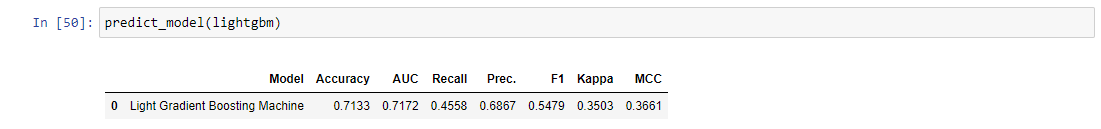

# From the above performances of all stack models  , blend models , and also custom models built on errors of previous model, we observed that initial lightgbm model has the best performance and we will be using that for deployment.